In [2]:
from molmap.model import RegressionEstimator, MultiClassEstimator, MultiLabelEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from chembench import dataset
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from molmap import MolMap
from molmap import feature

def Rdsplit(df, random_state = 888, split_size = [0.8, 0.1, 0.1]):
    base_indices = np.arange(len(df)) 
    base_indices = shuffle(base_indices, random_state = random_state) 
    nb_test = int(len(base_indices) * split_size[2]) 
    nb_val = int(len(base_indices) * split_size[1]) 
    test_idx = base_indices[0:nb_test] 
    valid_idx = base_indices[(nb_test):(nb_test+nb_val)] 
    train_idx = base_indices[(nb_test+nb_val):len(base_indices)] 
    print(len(train_idx), len(valid_idx), len(test_idx)) 
    return train_idx, valid_idx, test_idx 

In [3]:
data = dataset.load_ClinTox()

total samples: 1478


## Pre-fit your molmap object 

In [4]:
mp1 = MolMap(ftype='descriptor',metric='cosine',)
mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15,)

2021-04-24 09:50:28,557 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-04-24 09:50:30,971 - INFO - [bidd-molmap] - Finished


In [5]:
bitsinfo = feature.fingerprint.Extraction().bitsinfo
flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP'])].IDs.tolist()
mp2 = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) # 
mp2.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)

2021-04-24 09:50:35,700 - INFO - [bidd-molmap] - Applying naive scatter feature map...
2021-04-24 09:50:35,708 - INFO - [bidd-molmap] - Finished


## Extract Fmaps

In [6]:
X1 = mp1.batch_transform(data.x)
X2 = mp2.batch_transform(data.x)

100%|##########| 1478/1478 [00:50<00:00, 29.33it/s]


In [7]:
Y = data.y
Y = np.nan_to_num(Y, nan=-1)

In [8]:
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 123)
trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX = (X1[test_idx], X2[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

1184 147 147


In [19]:
# define your model, note that if your task is a multi-label problem, you should use MultiLabelEstimator
clf = MultiLabelEstimator(n_outputs=trainY.shape[1], 
                          fmap_shape1 = X1.shape[1:],
                          fmap_shape2 = X2.shape[1:],
                          metric='ROC', 
                          dense_layers = [256, 128],  gpuid = 0) 

MultiLabelEstimator(dense_layers=[256, 128], gpuid='0')


In [20]:
# fit your model
clf.fit(trainX, trainY, validX, validY )

epoch: 0001, loss: 0.6199 - val_loss: 0.4821; auc: 0.3676 - val_auc: 0.3516                                                                                                    
epoch: 0002, loss: 0.3995 - val_loss: 0.3098; auc: 0.3506 - val_auc: 0.3118                                                                                                    
epoch: 0003, loss: 0.2714 - val_loss: 0.2774; auc: 0.3544 - val_auc: 0.3115                                                                                                    
epoch: 0004, loss: 0.2561 - val_loss: 0.2800; auc: 0.3734 - val_auc: 0.3322                                                                                                    
epoch: 0005, loss: 0.2523 - val_loss: 0.2716; auc: 0.4142 - val_auc: 0.3829                                                                                                    
epoch: 0006, loss: 0.2490 - val_loss: 0.2685; auc: 0.4650 - val_auc: 0.4525                                             

MultiLabelEstimator(dense_layers=[256, 128], gpuid='0')

## plot training history

<AxesSubplot:>

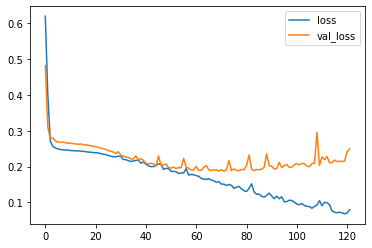

In [21]:
pd.DataFrame(clf.history.history).plot()

In [22]:
print('Best epochs: %.2f, Best loss: %.2f' % (clf._performance.best_epoch, clf._performance.best))

Best epochs: 71.00, Best loss: 0.19


# performance on  test set

In [23]:
clf.evaluate(testX, testY) 

[0.9052469135802469, 0.8375430539609643]

In [24]:
df_pred = pd.DataFrame([testY[:, 0], clf.predict_proba(testX)[:,0]]).T
df_pred.columns=['y_true', 'y_pred_prob']

In [25]:
df_pred.head(5)

,y_true,y_pred_prob
0,1.0,0.947581
1,1.0,0.992366
2,1.0,0.993810
3,0.0,0.738636
4,1.0,0.967043


<AxesSubplot:>

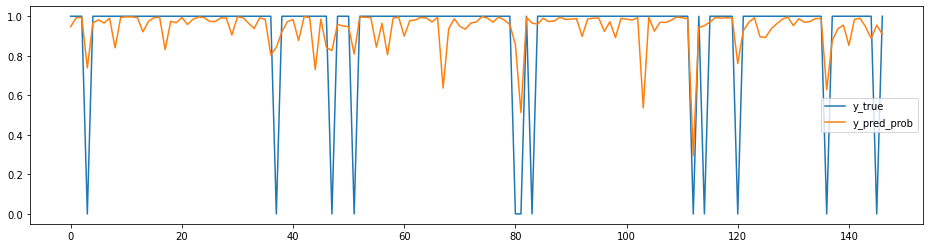

In [26]:
df_pred.plot(figsize=(16, 4))